In [39]:
import os
os.chdir('/content/drive/MyDrive/viact1')
!ls

output	test2.json  test_image	train1.json  train2.json  train_image


In [40]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [41]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [42]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# import some common libraries
import numpy as np
import cv2
import random
import os
import torch

from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.data import DatasetMapper
from detectron2.data.datasets import register_coco_instances

In [44]:
register_coco_instances("qi_train2", {}, "/content/drive/MyDrive/viact1/train2.json", "/content/drive/MyDrive/viact1/train_image")
register_coco_instances("qi_test2", {}, "/content/drive/MyDrive/viact1/test2.json", "/content/drive/MyDrive/viact1/test_image")

In [45]:
from detectron2.data.catalog import DatasetCatalog
qi_train_metadata = MetadataCatalog.get("qi_train2")
dataset_dicts = DatasetCatalog.get("qi_train2")

print(qi_train_metadata)

WARNING [04/26 04:41:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/26 04:41:50 d2.data.datasets.coco]: Loaded 1476 images in COCO format from /content/drive/MyDrive/viact1/train2.json
Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/viact1/train_image', json_file='/content/drive/MyDrive/viact1/train2.json', name='qi_train2', thing_classes=['Helmet and Mask present', 'Mask available', 'No Helmet and Mask present', 'Safety Helmet present'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3})


In [46]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("qi_train2",)
cfg.DATASETS.TEST = ("qi_test2",)

cfg.MODEL.WEIGHTS = cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.001

cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.SOLVER.WARMUP_FACTOR = 1.0/1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 10000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (3000, 5500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.CHECKPOINT_PERIOD = 5000


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000 #added 1
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000 #added 2


In [47]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

In [48]:
class CocoTrainer(DefaultTrainer):
 
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)


In [49]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/26 04:42:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[04/26 04:42:10 d2.engine.train_loop]: Starting training from iteration 0
[04/26 04:42:19 d2.utils.events]:  eta: 1:13:55  iter: 19  total_loss: 2.067  loss_cls: 1.574  loss_box_reg: 0.4026  loss_rpn_cls: 0.0908  loss_rpn_loc: 0.0234  time: 0.4403  data_time: 0.0132  lr: 0.00019981  max_mem: 7575M
[04/26 04:42:28 d2.utils.events]:  eta: 1:13:43  iter: 39  total_loss: 1.336  loss_cls: 0.6867  loss_box_reg: 0.6033  loss_rpn_cls: 0.04009  loss_rpn_loc: 0.01848  time: 0.4386  data_time: 0.0055  lr: 0.00039961  max_mem: 7575M
[04/26 04:42:37 d2.utils.events]:  eta: 1:13:59  iter: 59  total_loss: 1.299  loss_cls: 0.5119  loss_box_reg: 0.6296  loss_rpn_cls: 0.04587  loss_rpn_loc: 0.02184  time: 0.4431  data_time: 0.0066  lr: 0.00059941  max_mem: 7575M
[04/26 04:42:46 d2.utils.events]:  eta: 1:13:39  iter: 79  total_loss: 1.313  loss_cls: 0.525  loss_box_reg: 0.6613  loss_rpn_cls: 0.04784  loss_rpn_loc: 0.0128  time: 0.4447  data_time: 0.0057  lr: 0.00079921  max_mem: 7575M
[04/26 04:42:55 d2.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7c3936a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[04/26 06:03:14 d2.evaluation.evaluator]: Inference done 90/632. 0.1261 s / img. ETA=0:01:09
[04/26 06:03:19 d2.evaluation.evaluator]: Inference done 129/632. 0.1263 s / img. ETA=0:01:04
[04/26 06:03:24 d2.evaluation.evaluator]: Inference done 169/632. 0.1259 s / img. ETA=0:00:59
[04/26 06:03:29 d2.evaluation.evaluator]: Inference done 208/632. 0.1260 s / img. ETA=0:00:54


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7c3936a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[04/26 06:03:34 d2.evaluation.evaluator]: Inference done 248/632. 0.1257 s / img. ETA=0:00:49
[04/26 06:03:39 d2.evaluation.evaluator]: Inference done 285/632. 0.1259 s / img. ETA=0:00:44
[04/26 06:03:45 d2.evaluation.evaluator]: Inference done 326/632. 0.1252 s / img. ETA=0:00:39
[04/26 06:03:50 d2.evaluation.evaluator]: Inference done 366/632. 0.1251 s / img. ETA=0:00:34
[04/26 06:03:55 d2.evaluation.evaluator]: Inference done 406/632. 0.1251 s / img. ETA=0:00:29
[04/26 06:04:00 d2.evaluation.evaluator]: Inference done 447/632. 0.1248 s / img. ETA=0:00:23
[04/26 06:04:05 d2.evaluation.evaluator]: Inference done 487/632. 0.1248 s / img. ETA=0:00:18
[04/26 06:04:10 d2.evaluation.evaluator]: Inference done 527/632. 0.1248 s / img. ETA=0:00:13
[04/26 06:04:15 d2.evaluation.evaluator]: Inference done 567/632. 0.1247 s / img. ETA=0:00:08
[04/26 06:04:20 d2.evaluation.evaluator]: Inference done 608/632. 0.1245 s / img. ETA=0:00:03
[04/26 06:04:23 d2.evaluation.evaluator]: Total inference ti

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("qi_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "qi_test")
inference_on_dataset(trainer.model, val_loader, evaluator)


**TO make a prediction on a single image**

In [50]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

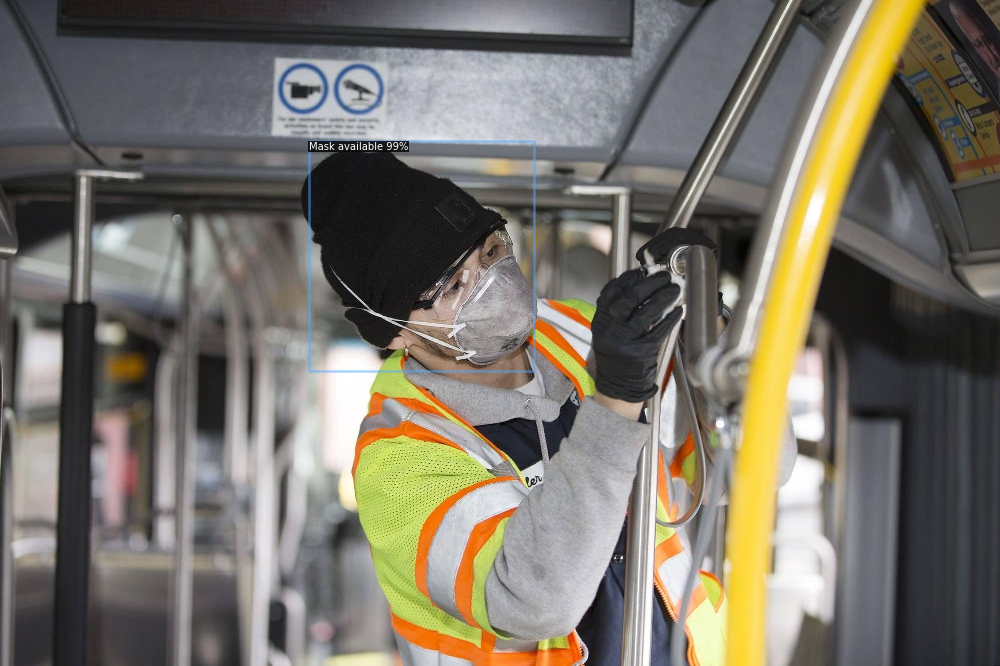

In [57]:
im = cv2.imread('/content/6.jpg')
outputs = predictor(im)
from google.colab.patches import cv2_imshow
v = Visualizer(im[:, :, ::-1],
                   metadata=qi_train_metadata, 
                   scale=0.5   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])